## 特徴量を選択しグリットサーチでトレーニングする

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters found: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation AUC: 0.8132699
Cross-Validation AUC Scores: [0.80337027 0.85741393 0.80309501 0.79652845 0.80594205]
Mean Cross-Validation AUC: 0.8132699420417346
Test AUC: 0.8338683052090975
過学習の兆候は見られません。


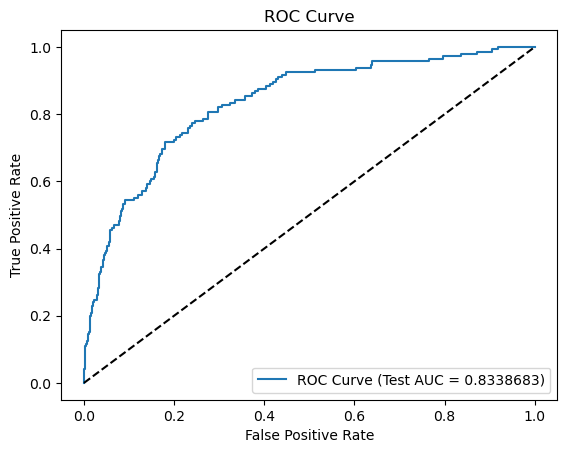

最適なロジスティック回帰モデルが /Users/hayakawakazue/Downloads/signate/model/logistic_regression0822_1.joblib に保存されました。
Recall: 0.22758620689655173
F1 Score: 0.34196891191709844
Accuracy: 0.8584169453734671
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.98      0.92       752
     Class 1       0.69      0.23      0.34       145

    accuracy                           0.86       897
   macro avg       0.78      0.60      0.63       897
weighted avg       0.84      0.86      0.83       897



In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0830_7.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'Passport', 'Product_Designation_Target_Encoding', 'Gender_Female', 'CityTier_Age_Income_Interaction',
    'Age_ProdTaken_Mean', 'Income_Bucket_Rank', 'FamilySize', 'TypeofContact_Company Invited', 
    'NumberOfPersonVisiting'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# データの前処理：nanを含む行を削除し、対応する y も削除
train_indices = X_train.dropna().index
X_train = X_train.loc[train_indices]
y_train = y_train.loc[train_indices]
test_indices = X_test.dropna().index
X_test = X_test.loc[test_indices]
y_test = y_test.loc[test_indices]

# ハイパーパラメータの候補を設定
param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['saga']
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'l1_ratio': [0, 0.5, 1]
    }
]

# ロジスティック回帰モデルの定義
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# グリッドサーチの設定
lr_grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# グリッドサーチの実行
lr_grid_search.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {lr_grid_search.best_params_}")
print(f"Best cross-validation AUC: {lr_grid_search.best_score_:.7f}")

# 最適なモデルを取得
lr_best = lr_grid_search.best_estimator_

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(lr_best, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = lr_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'logistic_regression0822_1.joblib')
joblib.dump(lr_best, model_path)
print(f"最適なロジスティック回帰モデルが {model_path} に保存されました。")

from sklearn.metrics import recall_score, f1_score, accuracy_score, classification_report

# テストデータに対する予測を実施
y_pred = lr_best.predict(X_test)

# リコールの計算
recall = recall_score(y_test, y_pred)

# F1スコアの計算
f1 = f1_score(y_test, y_pred)

# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)



## 特徴量を選択してランダムサーチでトレーニングする

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.5, 'C': 1}
Best cross-validation AUC: 0.7958
Cross-Validation AUC Scores: [0.79075704 0.80453005 0.80236977 0.79168343 0.78949251]
Mean Cross-Validation AUC: 0.7957665625463142
Test AUC: 0.8260425780110818
過学習の兆候は見られません。


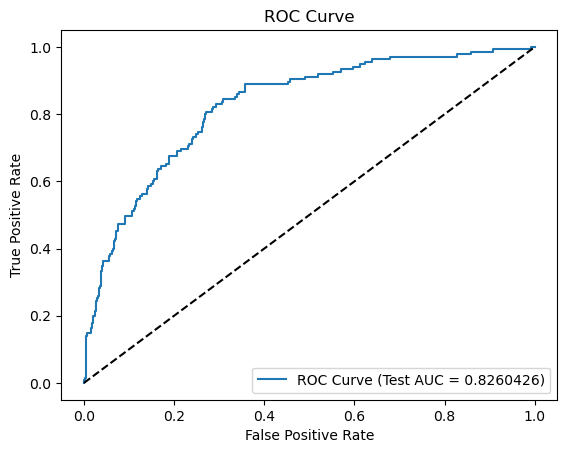

最適なロジスティック回帰モデルが /Users/hayakawakazue/Downloads/signate/model/logistic_regression_best0830_1.joblib に保存されました。


In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
import os
import joblib
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0830_7.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量を選択する
selected_features = [
    'Product_Designation_Target_Encoding', 'Passport',
    'Gender_Female', 'CityTier_Age_Income_x_FamilySize_Income',
    'Income_Bucket_Rank', 'Age_ProdTaken_Mean', 'TypeofContact_Company_Invited'
]

# 特徴量とターゲットに分割
X = train_data[selected_features]
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)
# データの前処理：nanを含む行を削除し、対応する y も削除
train_indices = X_train.dropna().index
X_train = X_train.loc[train_indices]
y_train = y_train.loc[train_indices]
test_indices = X_test.dropna().index
X_test = X_test.loc[test_indices]
y_test = y_test.loc[test_indices]

# ハイパーパラメータの候補を設定
param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.005, 0.01, 0.1, 1],
        'solver': ['saga']
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1],
        'solver': ['saga'],
        'l1_ratio': [0.01, 0.1, 0.5]  # elasticnetの場合にのみ使用
    }
]

# ロジスティック回帰モデルの定義
lr_model = LogisticRegression(max_iter=2000, random_state=21)

# ランダムサーチの設定
lr_random_search = RandomizedSearchCV(estimator=lr_model, param_distributions=param_grid, n_iter=10, cv=5, scoring='roc_auc', 
                                      n_jobs=-1, verbose=1, random_state=21)

# ランダムサーチの実行
lr_random_search.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {lr_random_search.best_params_}")
print(f"Best cross-validation AUC: {lr_random_search.best_score_:.4f}")

# 最適なモデルを取得
lr_best = lr_random_search.best_estimator_

#最適なモデルで再トレーニング
lr_best.fit(X_train, y_train)

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(lr_best, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = lr_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = '/Users/hayakawakazue/Downloads/signate/model/logistic_regression_best0830_1.joblib'
joblib.dump(lr_best, model_path)
print(f"最適なロジスティック回帰モデルが {model_path} に保存されました。")           


## モデルが重視する特徴量を可視化する

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters found: {'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 0.1}
Best cross-validation AUC: 0.8009
Cross-Validation AUC Scores: [0.81364624 0.82733594 0.79303496 0.79581568 0.77484993]
Mean Cross-Validation AUC: 0.8009365493263798
Test AUC: 0.8056665859173128
Model's most important features:
                             Feature  Coefficient
20               ProductPitched_Rank    -0.678181
7                           Passport     0.393038
25                     AgeGroup_Rank    -0.240517
1                           CityTier     0.237000
22                Income_Bucket_Rank    -0.233468
21                  Designation_Rank    -0.196375
32                       Gender_Male     0.184193
31                     Gender_Female    -0.184193
12                        FamilySize    -0.152218
42  MaritalStatus_Income_Interaction     0.151518
29               Occupation_Salaried    -0.105356


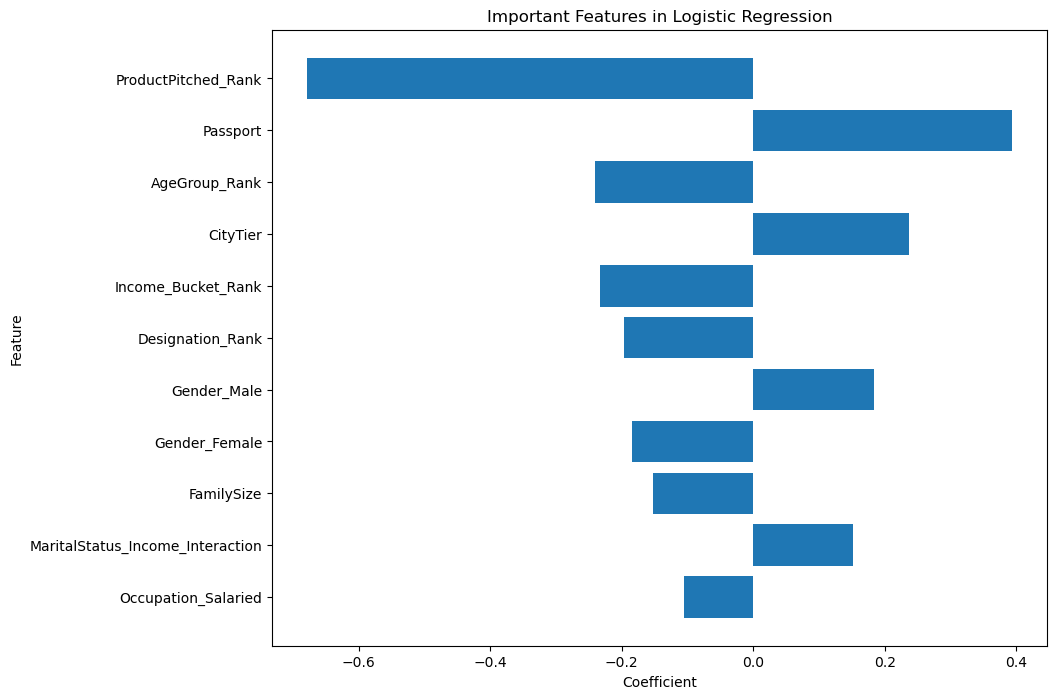

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_scaled0901_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

# パイプラインを構築してスケーリングとロジスティック回帰を組み合わせる
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=15))
])

# ハイパーパラメータの候補を設定
param_grid = [
    {
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [0.01, 0.1, 1],
        'classifier__solver': ['saga']
    },
    {
        'classifier__penalty': ['elasticnet'],
        'classifier__C': [0.001, 0.005, 0.01, 0.1, 1],
        'classifier__solver': ['saga'],
        'classifier__l1_ratio': [0.1, 0.5, 0.9]
    }
]

# ランダムサーチの設定
lr_random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=20, cv=5, 
                                      scoring='roc_auc', n_jobs=-1, verbose=1, random_state=15)

# ランダムサーチの実行
lr_random_search.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {lr_random_search.best_params_}")
print(f"Best cross-validation AUC: {lr_random_search.best_score_:.4f}")

# 最適なモデルを取得
lr_best = lr_random_search.best_estimator_

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(lr_best, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = lr_best.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# モデルが重視する特徴量を可視化
coefficients = lr_best.named_steps['classifier'].coef_[0]
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# しきい値を設定して重要な特徴量だけを選択
threshold = 0.1
important_features_df = feature_importance_df[np.abs(feature_importance_df['Coefficient']) > threshold].copy()

# 係数の絶対値でソート
important_features_df['AbsCoefficient'] = np.abs(important_features_df['Coefficient'])
important_features_df = important_features_df.sort_values(by='AbsCoefficient', ascending=False)

# 重要な特徴量のリストを表示
print("Model's most important features:")
print(important_features_df[['Feature', 'Coefficient']])

# 重要な特徴量を上位に表示するプロット
plt.figure(figsize=(10, 8))
plt.barh(important_features_df['Feature'], important_features_df['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Important Features in Logistic Regression')
plt.gca().invert_yaxis()
plt.show()


## LogisticRegression | REF→SMOTE→StratifiedKHold→GridSearch→CV

Selected features: ['NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'MaritalStatus', 'CarCount', 'Age_ProdTaken_Mean', 'Income_ProdTaken_Mean', 'FamilySize', 'Age_MonthlyIncome_Interaction', 'Age_DurationOfPitch', 'Income_Per_Age', 'Satisfaction_PerVisitor', 'ProductPitched_Rank', 'Designation_Rank', 'Income_Bucket_Rank', 'DurationOfPitch_Category_Rank', 'TypeofContact_Company Invited', 'Occupation_Large Business', 'Occupation_Salaried', 'Occupation_Small Business', 'Gender_Female', 'CityTier_Age_Income_Interaction', 'FamilySize_Income_Interaction', 'EngagementScore', 'ProductPitched_Satisfaction', 'Cluster', 'Cluster_ProdTaken_Ratio', 'Product_Designation_Target_Encoding']
Fitting 30 folds for each of 15 candidates, totalling 450 fits
Best parameters found: {'C': 0.1, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}
Best cross-validation AUC: 0.8333924
Cross-Validation AUC Scores: [0.78474576 0.79576271 0.78700565 0.83305

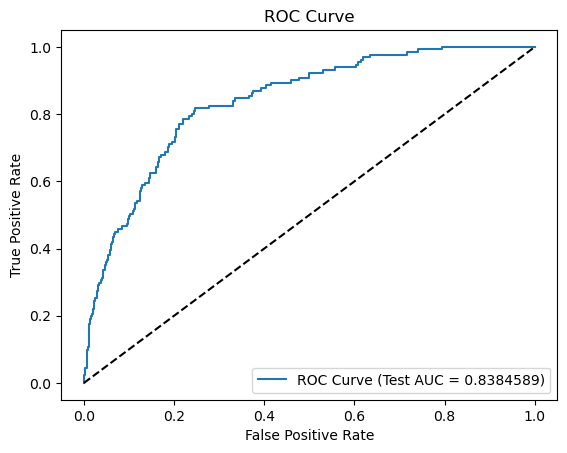

最適なロジスティック回帰モデルが /Users/hayakawakazue/Downloads/signate/model/logistic_regression_best0827_1.joblib に保存されました。
Recall: 0.8015267175572519
F1 Score: 0.4976303317535545
Accuracy: 0.7636566332218506
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.76      0.85       766
     Class 1       0.36      0.80      0.50       131

    accuracy                           0.76       897
   macro avg       0.66      0.78      0.67       897
weighted avg       0.87      0.76      0.79       897

Threshold: 0.6
Precision: 0.4018264840182648
Recall: 0.6717557251908397
F1 Score: 0.5028571428571429
Accuracy: 0.8060200668896321


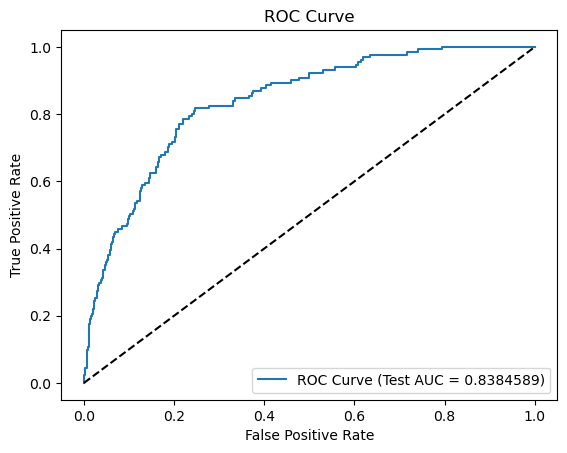

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.feature_selection import RFE
import joblib
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE


# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0821_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

# ロジスティック回帰モデルのインスタンスを作成
log_reg = LogisticRegression(random_state=18, solver='liblinear', max_iter=10000)

# RFEを使用して特徴量選択を実行 (30個の特徴量のみ選択)
selector = RFE(log_reg, n_features_to_select=30)
selector.fit(X_train, y_train)

# 選択された特徴量の名前をプリント
selected_features = X_train.columns[selector.support_]
print(f"Selected features: {selected_features.tolist()}")

# RFEで選択された特徴量でデータを変換
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# SMOTEを適用して不均衡データを解消
smote = SMOTE(random_state=10)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# StratifiedKFoldの定義
skf = StratifiedKFold(n_splits=30, shuffle=True, random_state=18)

# ハイパーパラメータの候補を設定 (さらに強い正則化)
param_grid = {
    'C': [0.01, 0.05, 0.1],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# グリッドサーチの設定
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=skf, scoring='roc_auc', n_jobs=-1, verbose=1)

# グリッドサーチの実行
grid_search.fit(X_train_smote, y_train_smote)

# 最適なモデルを取得
best_log_reg = grid_search.best_estimator_

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation AUC: {grid_search.best_score_:.7f}")

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(best_log_reg, X_train_smote, y_train_smote, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = best_log_reg.predict_proba(X_test_selected)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = '/Users/hayakawakazue/Downloads/signate/model/logistic_regression_best0827_1.joblib'
joblib.dump(best_log_reg, model_path)
print(f"最適なロジスティック回帰モデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = best_log_reg.predict(X_test_selected)

# リコールの計算
recall = recall_score(y_test, y_pred)

# F1スコアの計算
f1 = f1_score(y_test, y_pred)

# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test, y_pred)

# クラス別の詳細な評価指標の表示
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


# 閾値を0.5から変更して予測を行う（例: 0.6）
threshold = 0.6
y_pred_threshold = np.where(y_pred_proba >= threshold, 1, 0)

# 調整した閾値での性能評価
precision = precision_score(y_test, y_pred_threshold)
recall = recall_score(y_test, y_pred_threshold)
f1 = f1_score(y_test, y_pred_threshold)
accuracy = accuracy_score(y_test, y_pred_threshold)

print(f"Threshold: {threshold}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# ROC曲線をプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



## REF→SMOTE→StratifiedKHold→RandomizedSearch→CV

Selected features: ['NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'MaritalStatus', 'CarCount', 'Age_ProdTaken_Mean', 'Income_ProdTaken_Mean', 'FamilySize', 'Age_MonthlyIncome_Interaction', 'Age_DurationOfPitch', 'Income_Per_Age', 'Satisfaction_PerVisitor', 'ProductPitched_Rank', 'Designation_Rank', 'Income_Bucket_Rank', 'DurationOfPitch_Category_Rank', 'TypeofContact_Company Invited', 'Occupation_Large Business', 'Occupation_Salaried', 'Occupation_Small Business', 'Gender_Female', 'CityTier_Age_Income_Interaction', 'FamilySize_Income_Interaction', 'EngagementScore', 'ProductPitched_Satisfaction', 'Cluster', 'Cluster_ProdTaken_Ratio', 'Product_Designation_Target_Encoding']
Fitting 30 folds for each of 15 candidates, totalling 450 fits
Best parameters found: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.1, 'C': 0.01}
Best cross-validation AUC: 0.8228798
Cross-Validation AUC Scores: [0.73353819 0.82484636 0.78884987 0.8033

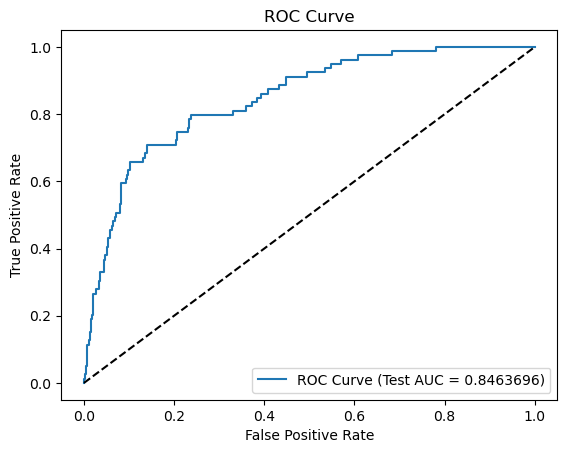

最適なロジスティック回帰モデルが /Users/hayakawakazue/Downloads/signate/model/logistic_regression0827_1.joblib に保存されました。
Recall: 0.7848101265822784
F1 Score: 0.4696969696969697
Accuracy: 0.7658862876254181
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.76      0.85       519
     Class 1       0.34      0.78      0.47        79

    accuracy                           0.77       598
   macro avg       0.65      0.77      0.66       598
weighted avg       0.88      0.77      0.80       598

Threshold: 0.6
Precision: 0.4344262295081967
Recall: 0.6708860759493671
F1 Score: 0.527363184079602
Accuracy: 0.8411371237458194


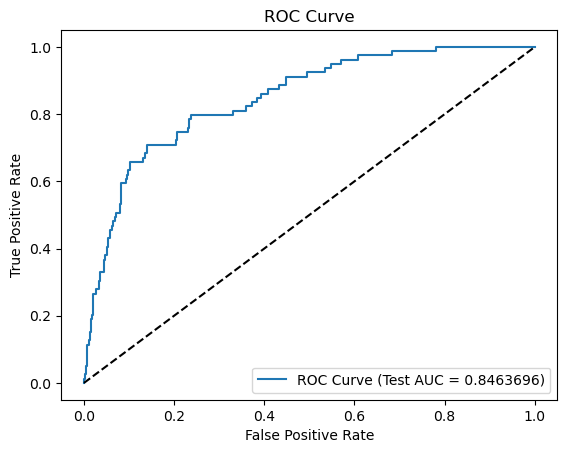

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.feature_selection import RFE
import joblib
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import os

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0821_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットに分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)


# ロジスティック回帰モデルのインスタンスを作成
log_reg = LogisticRegression(random_state=24, solver='liblinear', max_iter=10000)


# RFEを使用して特徴量選択を実行
selector = RFE(log_reg, n_features_to_select=30)
selector.fit(X_train, y_train)

# 選択された特徴量の名前をプリント
selected_features = X_train.columns[selector.support_]
print(f"Selected features: {selected_features.tolist()}")

# RFEで選択された特徴量でデータを変換
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# SMOTEを適用して不均衡データを解消
smote = SMOTE(random_state=10)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# StratifiedKFoldの定義
skf = StratifiedKFold(n_splits=30, shuffle=True, random_state=24)

# ハイパーパラメータの設定
param_dist = {
    'C': [0.001, 0.005, 0.01],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

#ランダムサーチの設定
random_search = RandomizedSearchCV(
    estimator=log_reg, 
    param_distributions=param_dist, 
    n_iter=15, 
    cv=skf, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1, 
    random_state=20
)

# ランダムサーチの実行
random_search.fit(X_train_smote, y_train_smote)

# 最適なモデルを取得
best_log_reg = random_search.best_estimator_

# 最適なハイパーパラメータの表示
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation AUC: {random_search.best_score_:.7f}")

# クロスバリデーションを使用してトレーニングデータでのAUCを計算
cv_scores = cross_val_score(best_log_reg, X_train_smote, y_train_smote, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC: {cv_scores.mean()}")

# テストデータでの予測とAUC計算
y_pred_proba = best_log_reg.predict_proba(X_test_selected)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {test_auc}")

# 過学習の有無をチェック
if cv_scores.mean() > test_auc:
    print(f"過学習の可能性があります: Cross-Validation AUCがTest AUCを{cv_scores.mean() - test_auc:.7f}だけ上回っています。")
else:
    print("過学習の兆候は見られません。")

# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 最適なモデルの保存
model_path = os.path.join('/Users/hayakawakazue/Downloads/signate/model', 'logistic_regression0827_1.joblib')
joblib.dump(best_log_reg, model_path)
print(f"最適なロジスティック回帰モデルが {model_path} に保存されました。")

# テストデータに対する予測を実施
y_pred = best_log_reg.predict(X_test_selected)

# リコールの計算
recall = recall_score(y_test, y_pred)
# F1スコアの計算
f1 = f1_score(y_test, y_pred)
# 正確度（Accuracy）の計算
accuracy = accuracy_score(y_test, y_pred)
# クラス別の詳細な評価指標の表示
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
# 結果を表示
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# 閾値を0.5から変更して予測を行う（例: 0.6）
threshold = 0.6
y_pred_threshold = np.where(y_pred_proba >= threshold, 1, 0)

# 調整した閾値での性能評価
precision = precision_score(y_test, y_pred_threshold)
recall = recall_score(y_test, y_pred_threshold)
f1 = f1_score(y_test, y_pred_threshold)
accuracy = accuracy_score(y_test, y_pred_threshold)
print(f"Threshold: {threshold}")

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# ROC曲線をプロット
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (Test AUC = {test_auc:.7f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## モデルが重視する特徴量を可視化する

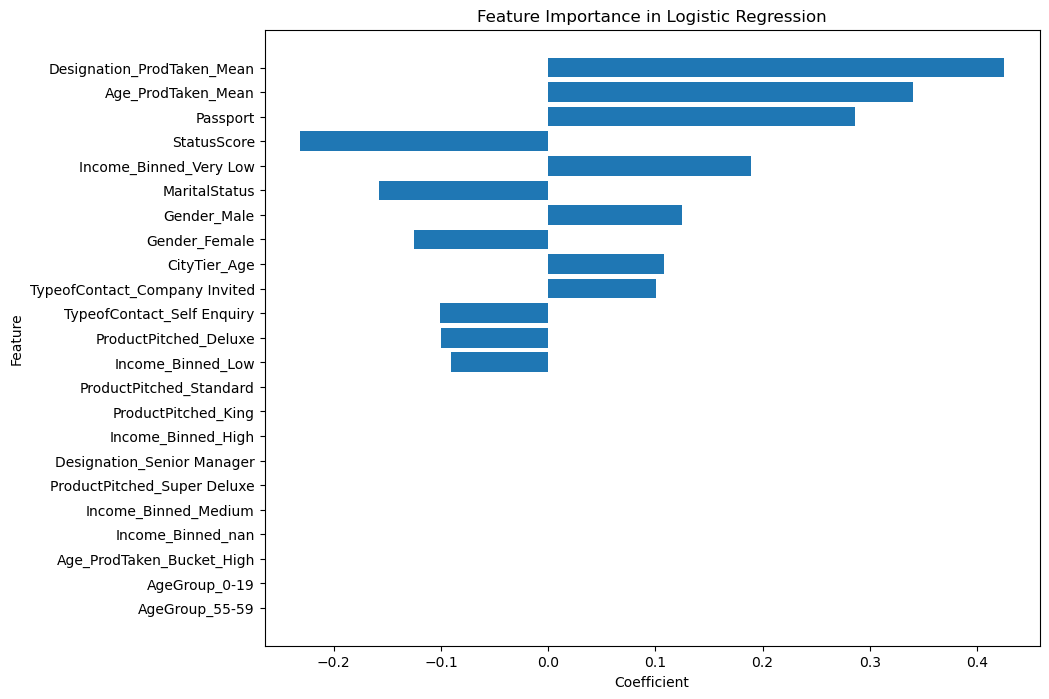

Selected features: ['Passport', 'MaritalStatus', 'Designation_ProdTaken_Mean', 'Age_ProdTaken_Mean', 'CityTier_Age', 'TypeofContact_Company Invited', 'TypeofContact_Self Enquiry', 'Gender_Female', 'Gender_Male', 'ProductPitched_Deluxe', 'ProductPitched_King', 'ProductPitched_Standard', 'ProductPitched_Super Deluxe', 'Designation_Senior Manager', 'Income_Binned_High', 'Income_Binned_Low', 'Income_Binned_Medium', 'Income_Binned_Very Low', 'Income_Binned_nan', 'Age_ProdTaken_Bucket_High', 'AgeGroup_0-19', 'AgeGroup_55-59', 'StatusScore']


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'log_reg_best' is your trained logistic regression model
# and 'selector' is your RFE selector

# If using RFE, get the selected feature names
selected_features = X_train.columns[selector.support_]

# Get the coefficients from the model
coefficients = log_reg_best.coef_[0]

# Create a DataFrame to store feature names and their corresponding coefficients
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients
})

# Sort the DataFrame by the absolute value of the coefficients
feature_importance_df['AbsCoefficient'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='AbsCoefficient', ascending=False)

# Plot the coefficients
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

# 選択された特徴量の名前を取得
selected_features = X_train.columns[selector.support_]
print(f"Selected features: {selected_features.tolist()}")